In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm

rng = np.random.default_rng()

In [34]:
class SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej', 'log_vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_dict):
        self.true_class = true_class
        if self.true_class == 'ia':
            self.true_params = {key:true_dict[key] for key in self.ia_keys}
        elif self.true_class == 'ibc':
            self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        else:
            raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}
        self.ibc_fit.update({'log_vej': np.log10(self.ibc_fit['vej'])})

In [35]:
data = np.load("fitted_sne.npz", allow_pickle=True)
true_ia_sne = data['ia']
true_ibc_sne = data['ibc']
all_sne = np.concatenate((true_ia_sne, true_ibc_sne))
len(true_ibc_sne), len(all_sne)


(100, 200)

In [36]:
for sn in all_sne:
    sn.ibc_fit.update({'log_vej': np.log10(sn.ibc_fit['vej'])})

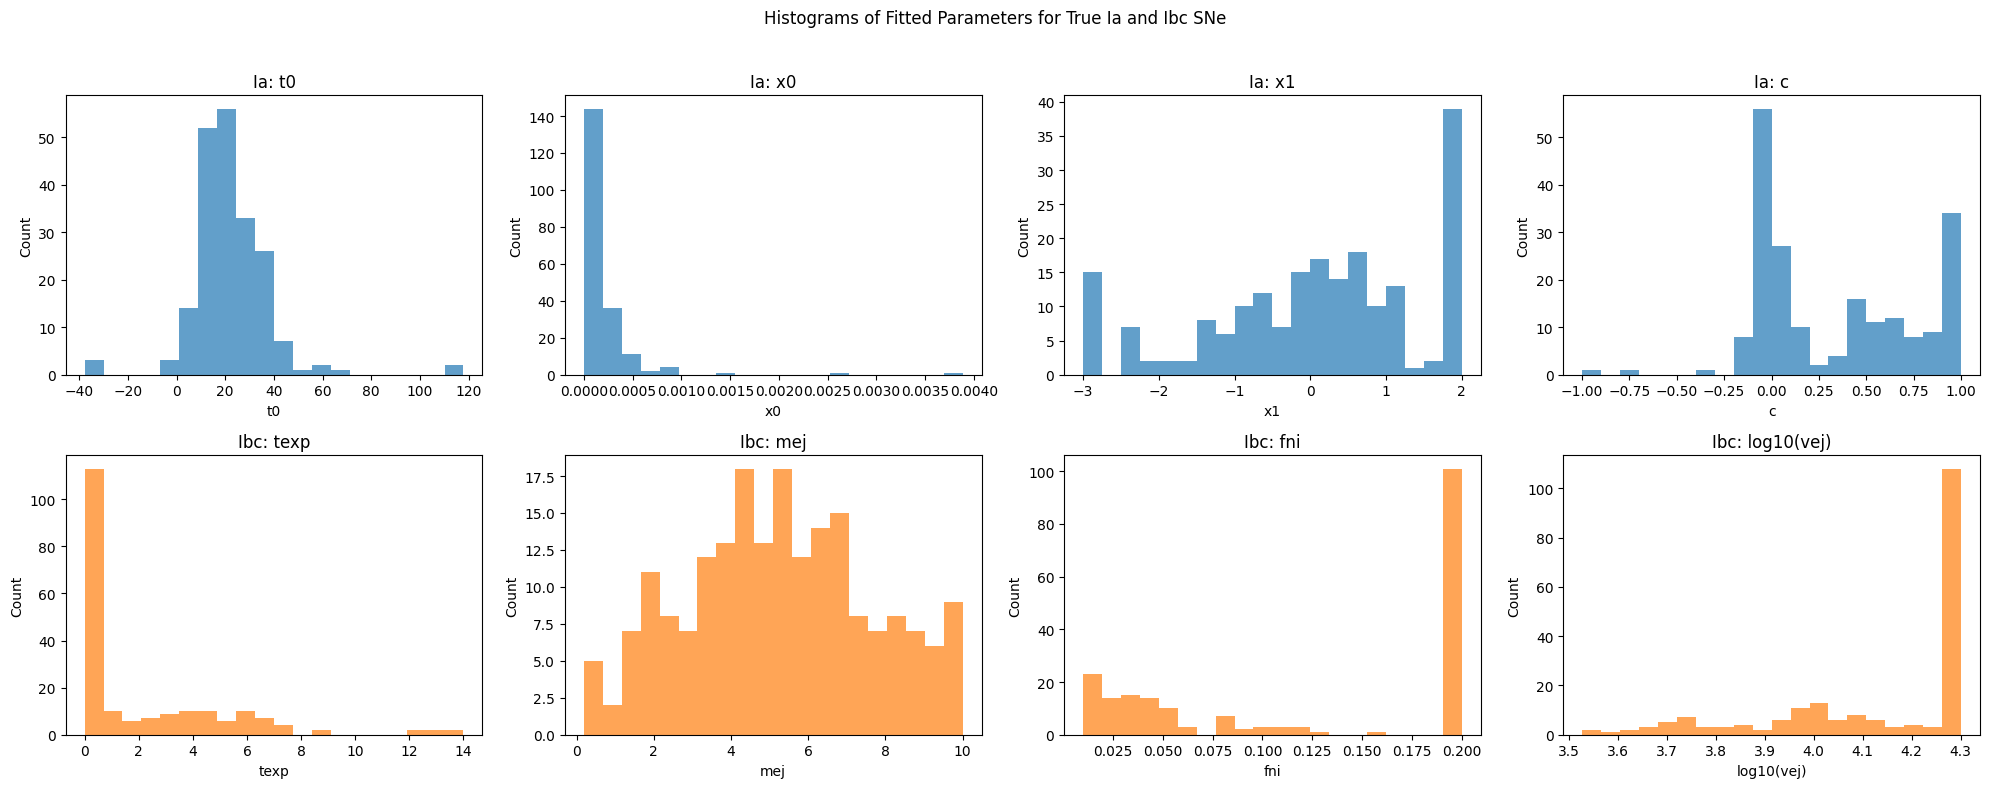

In [42]:
ia_param_names = SN.ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = SN.ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names):
    values = [sn.ia_fit[param] for sn in all_sne if sn.ia_fit[param] is not None]
    axes[0, i].hist(values, bins=20, color='tab:blue', alpha=0.7)
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values = [sn.ibc_fit[param] for sn in all_sne if sn.ibc_fit[param] is not None]
    if param == 'vej':
        # Plot log10 for vej
        values = [np.log10(v) for v in values if v > 0]
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Here we have 8 parameters that we can use to constrain the mixing fraction

In [39]:
# This is the log likelihood function for the distribution of one parameter 
# assuming a mixture of two Gaussians.
# x is the parameter value, samples are the observed data, and alpha is the mixing fraction
def log_likelihood(x, samples, alpha):
    mu1, sigma1, mu2, sigma2 = x
    first_term = alpha * norm.pdf(samples, mu1, sigma1)
    second_term = (1 - alpha) * norm.pdf(samples, mu2, sigma2)
    return np.sum(np.log(first_term + second_term))

In [47]:
def get_param_samples(param_name):
    if param_name in ia_param_names:
        return np.array([sn.ia_fit[param_name] for sn in all_sne])
    elif param_name in ibc_param_names:
        return np.array([sn.ibc_fit[param_name] for sn in all_sne])
    else:
        raise ValueError(f"Parameter {param_name} not recognized in either Ia or Ibc SNe.")

(array([  3.,   5.,  12.,   6.,   6.,  17.,  19.,  14.,   7., 111.]),
 array([3.52787401, 3.60518961, 3.68250521, 3.75982081, 3.83713641,
        3.914452  , 3.9917676 , 4.0690832 , 4.1463988 , 4.2237144 ,
        4.30103   ]),
 <BarContainer object of 10 artists>)

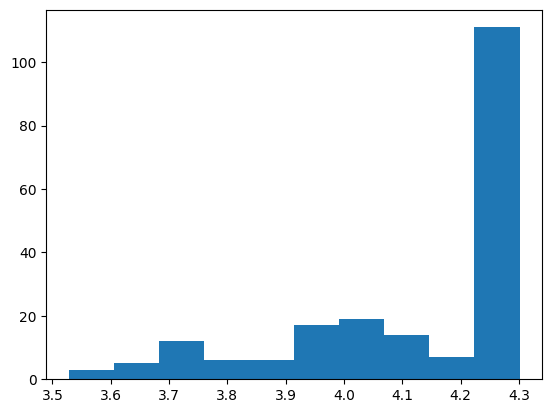

In [153]:
plt.hist(get_param_samples('log_vej'))

In [154]:
num_epochs = 200
lls = np.zeros(num_epochs)

mus_a = {'t0': 20, 'x0': 0.0001, 'x1': -1, 'c': 0, 'texp': 1, 'mej': 5, 'fni': 0.03, 'log_vej': 3.8}
mus_b = {'t0': 20, 'x0': 0.0001, 'x1': 0.1, 'c': 0.6, 'texp': 5, 'mej': 5, 'fni': 0.18, 'log_vej': 4.2}
sigmas_a = {'t0': 10, 'x0': 5e-4, 'x1': 1, 'c': 0.1, 'texp': 0.2, 'mej': 4, 'fni': 0.005, 'log_vej': 0.2}
sigmas_b = {'t0': 10, 'x0': 5e-4, 'x1': 1, 'c': 0.3, 'texp': 3, 'mej': 4, 'fni': 1e-3, 'log_vej': 0.05}

alphas = np.zeros(num_epochs)  # Store alpha values for each epoch
alpha = 0.4  # Mixing fraction
gammas_a = {'texp': [], 'mej': [], 'fni': [], 'log_vej': [], 't0': [], 'x0': [], 'x1': [], 'c': []}
gammas_b = {'texp': [], 'mej': [], 'fni': [], 'log_vej': [], 't0': [], 'x0': [], 'x1': [], 'c': []}

params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'x0', 'fni', 'log_vej']
# params_to_use = list(mus_a.keys())  # Use all parameters for fitting



# there are two populations, a and b
for epoch in range(num_epochs):
    # for param_name in list(mus_a.keys())[:3]:
    for param_name in params_to_use:
        param_samples = get_param_samples(param_name)

        # plt.hist(param_samples)
        # plt.show()

        # print(mus_a[param_name], sigmas_a[param_name])
        # the gammas are weights for every sample
        gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
        gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])

        # Normalize over parameter
        gamma_total = (gammas_a[param_name] + gammas_b[param_name])
        gammas_a[param_name] /= gamma_total
        gammas_b[param_name] /= gamma_total
        

        mus_a[param_name] = np.sum(gammas_a[param_name] * param_samples) / np.sum(gammas_a[param_name])
        mus_b[param_name] = np.sum(gammas_b[param_name] * param_samples) / np.sum(gammas_b[param_name])
        sigmas_a[param_name] = np.sqrt(np.sum(gammas_a[param_name] * (param_samples - mus_a[param_name])**2) / np.sum(gammas_a[param_name]))
        sigmas_b[param_name] = np.sqrt(np.sum(gammas_b[param_name] * (param_samples - mus_b[param_name])**2) / np.sum(gammas_b[param_name]))

    
    # Here we can use information from all parameters to constrain the mixing fraction
    # alpha is the fraction of parameter a, parameter b has 1 - alpha
    alpha = np.mean(np.concatenate([gammas_a[param_name] for param_name in params_to_use]))
    alphas[epoch] = alpha
    print("Alpha", alpha)

    # Calculate log likelihood for the current epoch
    for param_name in params_to_use:
        lls[epoch] += log_likelihood([mus_a[param_name], sigmas_a[param_name], mus_b[param_name], sigmas_b[param_name]], get_param_samples(param_name), alpha)

    

Alpha 0.36627621538343647
Alpha 0.35819847165030244
Alpha 0.3852345340739373
Alpha 0.4274761686471729
Alpha 0.4529355457159678
Alpha 0.46810882509134444
Alpha 0.4790992146554916
Alpha 0.4857743870053311
Alpha 0.4892521629786943
Alpha 0.4917191079529355
Alpha 0.49315721067822876
Alpha 0.4947341904013288
Alpha 0.4984785615931384
Alpha 0.5181295997119507
Alpha 0.5329150081342138
Alpha 0.5406308534999056
Alpha 0.5441221032697563
Alpha 0.5449533033123294
Alpha 0.5446342454589385
Alpha 0.5458486441409116
Alpha 0.5503663855693649
Alpha 0.5529122012695293
Alpha 0.5536258365104203
Alpha 0.5534519087621829
Alpha 0.5529421651515389
Alpha 0.5523431076560155
Alpha 0.5517546761821612
Alpha 0.5512130877117742
Alpha 0.5507275496934796
Alpha 0.5502962637930063
Alpha 0.5499134678973732
Alpha 0.5495725064847538
Alpha 0.5492670956458993
Alpha 0.5489917640346205
Alpha 0.5487419281569582
Alpha 0.5485138187475722
Alpha 0.5483043586630688
Alpha 0.5481110370785645
Alpha 0.547931797371202
Alpha 0.54776494395024

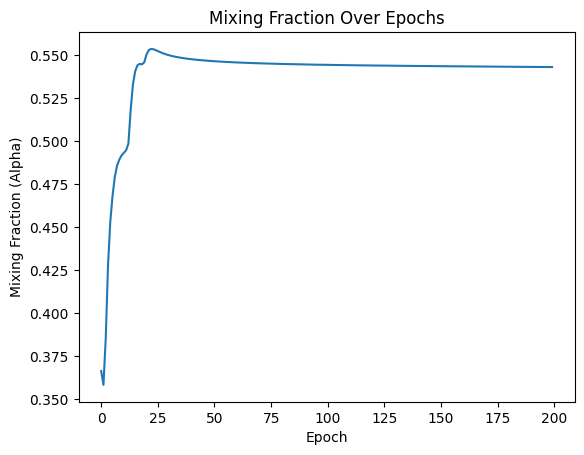

In [155]:
plt.plot(alphas)
plt.xlabel("Epoch")
plt.ylabel("Mixing Fraction (Alpha)")
plt.title("Mixing Fraction Over Epochs")
plt.show()

In [156]:
lls

array([-352.78181554,  527.12144691, 1320.52026873, 1510.38575662,
       1670.3848399 , 1902.05208105, 2256.55120169, 3282.21589871,
       3498.68069311, 3750.2618241 , 3889.74935694, 4010.32359706,
       4117.87377968, 4180.08485107, 4217.68618518, 4248.89637215,
       4258.82035238, 4260.12866058, 4268.34608419, 4285.12709036,
       4291.3009571 , 4292.87938706, 4293.35050201, 4293.53749764,
       4293.63090958, 4293.68607867, 4293.72285169, 4293.74950502,
       4293.76993884, 4293.78620197, 4293.79947995, 4293.81051809,
       4293.81981783, 4293.82773503, 4293.83453269, 4293.8404112 ,
       4293.84552679, 4293.85000341, 4293.85394075, 4293.85741989,
       4293.86050736, 4293.86325821, 4293.8657183 , 4293.86792606,
       4293.86991391, 4293.87170931, 4293.87333564, 4293.87481292,
       4293.87615834, 4293.87738673, 4293.87851094, 4293.87954214,
       4293.88049006, 4293.88136323, 4293.88216914, 4293.88291436,
       4293.88360471, 4293.88424535, 4293.88484085, 4293.88539

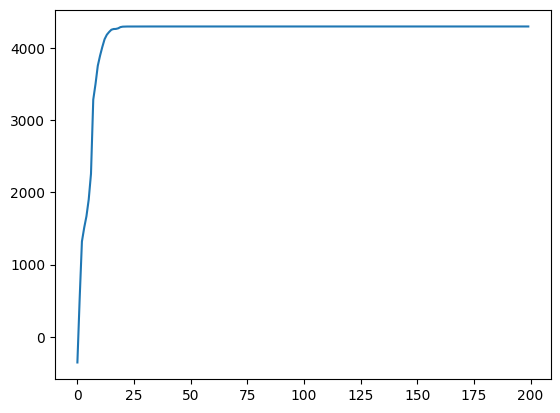

In [157]:
plt.plot(lls)

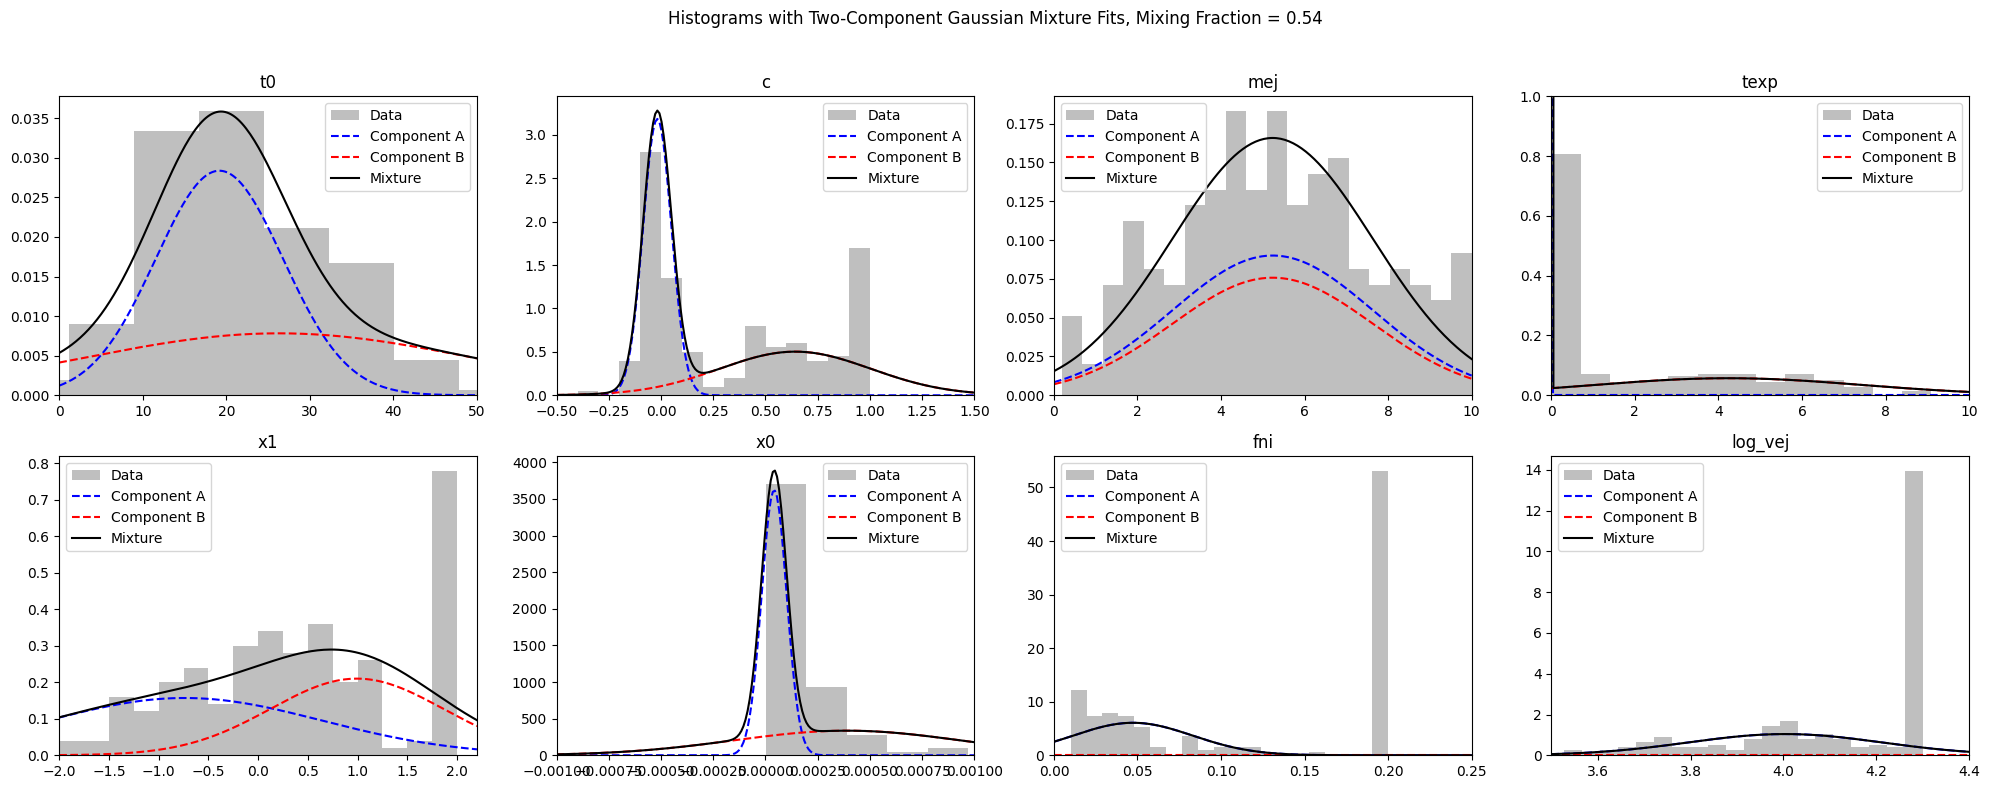

In [162]:
x_ranges = {
    't0': np.linspace(0, 50, 200),
    'x0': np.linspace(-0.001, 0.001, 200),
    'x1': np.linspace(-2, 2.2, 200),
    'c': np.linspace(-0.5, 1.5, 200),
    'texp': np.linspace(0, 10, 200),
    'mej': np.linspace(0, 10, 200),
    'fni': np.linspace(0, 0.25, 200),
    'log_vej': np.linspace(3.5, 4.4, 200)
}

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms with Two-Component Gaussian Mixture Fits, Mixing Fraction = {:.2f}".format(alpha))

for idx, param in enumerate(params_to_use):
    samples = get_param_samples(param)
    ax = axes.flat[idx]
    ax.hist(samples, bins=20, density=True, alpha=0.5, color='gray', label='Data')
    x = x_ranges[param]
    # Mixture fit
    y_a = alpha * norm.pdf(x, mus_a[param], sigmas_a[param])
    y_b = (1 - alpha) * norm.pdf(x, mus_b[param], sigmas_b[param])
    y_mix = y_a + y_b
    ax.plot(x, y_a, 'b--', label='Component A')
    ax.plot(x, y_b, 'r--', label='Component B')
    ax.plot(x, y_mix, 'k-', label='Mixture')
    ax.set_title(param)
    ax.set_xlim(x[0], x[-1])  # Ensure curves span the full x range
    if param == 'texp':
        ax.set_ylim(0, 1)  # Reduce y-limits for texp to see the histogram
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()